
# So, is it the car or is it the driver, in ten parts

Well, I got this idea for your midterm when one of you asked the question in class "*so how do we model F1 with a Bayesian approach*"?

<br />
<center>
<img src="images/f1-2022.jpg" width=1000 />
</center>

The big question in F1 is [is it the car or is it the driver](https://www.total-motorsport.com/f1-car-or-driver-more-important/). We want to begin to answer this question with modern bayesian statistics.

We want to infer the **latent** (latent means *hidden*) parameters (how talented a F! driver is, how strong a F1 constructor is - these parameters are hidden to us) that are driving the data we observe (points), and be able to use these to predict ***future*** points by building a **model** for each car.

We want to start with some **prior** distributions, and use observations (past results) to refine our priors into **posteriors**. Points are a noisy measurement of car strength, so quantifying car strength **uncertainty** is important. It will help us determine where to bet less (cars we're weaker at predicting), and cars to bet more on (cars where uncertainty is minimal).

We will use a Poisson count model to model F1 car points, since [F1 points](https://en.wikipedia.org/wiki/Formula_One_racing) awarded, exclusively for positions 1 through 10, are integer points.

>*Points are awarded to drivers and teams based on where they finish in a race. The winner receives 25 points, the second-place finisher 18 points, with 15, 12, 10, 8, 6, 4, 2 and 1 points for positions 3 through 10, respectively*.

I did a bit of litterature research and found this interesting [paper](https://arxiv.org/pdf/2203.08489.pdf), which underscores that in a race, it's mostly about the car, rather than the driver.

>**Note**: We will simplify the paper's approach somewhat, but if you read the paper carefully, you will realize what a long trip we have taken together already and how much you've learned. This is an advanced research paper in data science, so if you feel somewhat comfortable reading it, well done student!

Let's see if this is true.

First, a bit about pymc3...

# About pymc3
`PyMC3` has been renamed to `PyMC`. PyMC3 version 3.x will stay under the current name to not break production systems

Here's what to remember:

- PyMC3 3.x: The version we all love and use, using the `theano-pymc` tensor
- PyMC version 4, with the latest version being 5.1.1: The successor to PyMC3, (mostly) API compatible, and main focus going forward.
- (PyMC4: A discontinued experiment with new API on the TensorFlow backend).

`Theano` is a computational graph library, compiling complex mathemtical operations into one graph that can be optimized (we experimented with similar optimizations when we contrasted lazy list comprehensions and generators versus eager list comprehensions and functions). Theano was absorbed into tensorflow, at which point the Theano authors (Montral university) discontinued it. The pymc3 authors then did what everyone would do: Upgrade pymc3 to use tensorflow, but they failed (thus discontinued `pymc4`). After rediscovering the power of Theano, the pymc3 authors forked Theano to `Theano-PyMC` (PyMC3 now relies on this fork), and then reforked to `aesara`, and then reforked to `pytensor`.

In v3, pymc3 was not really using the full power of Theano. While calling e.g. `x = pm.Normal('x')` created a `theano.TensorVariable` which can be manipulated further, like inputting it into another random variable, a full-fledged graph was not being built.

[Here's](https://gist.github.com/twiecki/0219d3fa059776b90af0f08b5452e346) more detail about all these shenanigans.

If you can run pymc3 with the theano tensor on your laptop (run first cell in this notebook), great, keep using it. Otherwise, please create a new environment and install pymc version 5.1.1 based on python 3.10:
```
conda install nb_conda_kernels
conda create -n pymc5 python=3.10
conda activate pymc5
conda install -c conda-forge pymc==5.1.1
pip install seaborn
conda install ipykernel
(restart anaconda kernel)
```

then open the notebook, go to kernels menu, and switch to your new environment by selecting the pymc5 kernel, and run the second cell in this notebook instead of the first cell. ***DO NOT*** run both cells. Pick the one you will use.

Run the cell below if you're using the `theano` tensor. If it works, keep using the theano tensor and ***do not run the second cell below***.

If you don't have `theano`, another option would be to stick with `pymc3` and replace `tt.exp` with `pm.math.exp` and `tt.mean` with `pm.math.sum(..)/num_teams` in setting up the simulation. So, you have a number of options.

In [1]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

# 1. The data for F1 season 2022
I found it [here](https://github.com/toUpperCase78/formula1-datasets)!


### Importing the dataset

In [2]:
df_races = pd.read_csv('data/Formula1_2022season_raceResults.csv')

In [3]:
df_races

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,+1 Pt,Fastest Lap
0,Bahrain,1,16,Charles Leclerc,Ferrari,1,57,1:37:33.584,26,Yes,1:34.570
1,Bahrain,2,55,Carlos Sainz,Ferrari,3,57,+5.598,18,No,1:35.740
2,Bahrain,3,44,Lewis Hamilton,Mercedes,5,57,+9.675,15,No,1:36.228
3,Bahrain,4,63,George Russell,Mercedes,9,57,+11.211,12,No,1:36.302
4,Bahrain,5,20,Kevin Magnussen,Haas Ferrari,7,57,+14.754,10,No,1:36.623
...,...,...,...,...,...,...,...,...,...,...,...
435,Abu Dhabi,16,47,Mick Schumacher,Haas Ferrari,12,57,+1 lap,0,No,1:29.833
436,Abu Dhabi,17,20,Kevin Magnussen,Haas Ferrari,16,57,+1 lap,0,No,1:31.158
437,Abu Dhabi,18,44,Lewis Hamilton,Mercedes,5,55,DNF,0,No,1:29.788
438,Abu Dhabi,19,6,Nicholas Latifi,Williams Mercedes,20,55,DNF,0,No,1:30.309


# 2. EDA
Do some data healing.

### 1. Checking dataTypes and Shape of the imported data

In [4]:
#Drop all 'NC' values from the dataframe

df_races = df_races.replace('NC',np.NaN)
df_races = df_races.dropna()

df_races['Position'] = pd.to_numeric(df_races['Position'])
df_races['Position'].dtypes

print(df_races.dtypes)
print(df_races.shape)

Track            object
Position          int64
No                int64
Driver           object
Team             object
Starting Grid     int64
Laps              int64
Time/Retired     object
Points            int64
+1 Pt            object
Fastest Lap      object
dtype: object
(376, 11)


### 2. Checking duplicate values

In [5]:
duplicate_rows_df = df_races[df_races.duplicated()]
print("Number of duplicate rows: \n",duplicate_rows_df.shape)
df_races.count
print("")

Number of duplicate rows: 
 (0, 11)



### 3. Checking if there are any null values.

In [6]:
print("Total null values:\n", df_races.isnull().sum())
df_races.isnull().style.set_table_styles([{'selector' : '',
                            'props' : [('border',
                                        '2px solid green')]}])

Total null values:
 Track            0
Position         0
No               0
Driver           0
Team             0
Starting Grid    0
Laps             0
Time/Retired     0
Points           0
+1 Pt            0
Fastest Lap      0
dtype: int64


,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,+1 Pt,Fastest Lap
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False


### 4. Understanding better with visualizations

/Users/keerthanaakannan/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


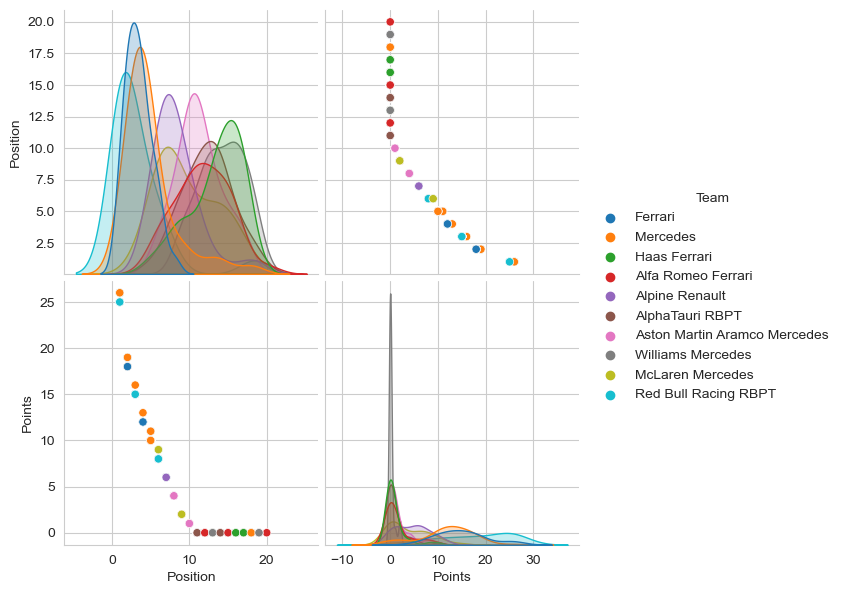

In [7]:
import seaborn as sns

d=df_races.Driver.unique()
t=df_races.Team.unique()
new = df_races.groupby(['Team'])['Driver']

sns.set_style("whitegrid");
df_races_positions = df_races[['Position', 'Driver','Team', 'Points']]
sns.pairplot(df_races_positions, hue="Team", size=3);
plt.show()

# 3. Points

Build the a dictionary that represents the race points won by a driver as a function of race finishing position. 
    
Then, build a pandas dataframe called df_races_positions with the same index as the df_races dataframe, but with only the following columns: Position, Driver, Team, Points.

In [8]:
race_points = {
    1: 25,    # if a driver finishes in 1st place, they earn 25 points
    2: 18,    # if a driver finishes in 2nd place, they earn 18 points
    3: 15,    # if a driver finishes in 3rd place, they earn 15 points
    4: 12,    # if a driver finishes in 4th place, they earn 12 points
    5: 10,    # if a driver finishes in 5th place, they earn 10 points
    6: 8,     # if a driver finishes in 6th place, they earn 8 points
    7: 6,     # if a driver finishes in 7th place, they earn 6 points
    8: 4,     # if a driver finishes in 8th place, they earn 4 points
    9: 2,     # if a driver finishes in 9th place, they earn 2 points
    10: 1,    # if a driver finishes in 10th place or lower, they earn 1 point
    11: 0,
    12: 0,
    13: 0,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0,
    19: 0,
    20: 0
}

df_races_positions = df_races[['Position', 'Driver','Team', 'Points']]
df_races_positions.head().style.set_table_styles([{'selector' : '',
                            'props' : [('border',
                                        '2px solid green')]}])

,Position,Driver,Team,Points
0,1,Charles Leclerc,Ferrari,26
1,2,Carlos Sainz,Ferrari,18
2,3,Lewis Hamilton,Mercedes,15
3,4,George Russell,Mercedes,12
4,5,Kevin Magnussen,Haas Ferrari,10


Then, build the following dataframes (in full) representing driver + team and total points for the season, and team and points for the season:
```
	Position	Points
Driver	Team		
Max Verstappen	Red Bull Racing RBPT	59	428
Charles Leclerc	Ferrari	63	288
Sergio Perez	Red Bull Racing RBPT	79	288
George Russell	Mercedes	92	259
Lewis Hamilton	Mercedes	113	231
...
```

```
Position	Points
Team		
Red Bull Racing RBPT	138	716
Ferrari	119	514
Mercedes	205	490
Alpine Renault	311	170
...
```


In [9]:
# Use groupby to aggregate the points by driver and team

df_races_positions.loc[df_races['+1 Pt']=='Yes','Points']-=1
driver_points_df = df_races_positions.groupby(['Driver', 'Team']).agg({'Position': 'sum', 'Points': 'sum'}).reset_index()
driver_points_df = driver_points_df
print(driver_points_df)
print(" ")

# Use groupby to aggregate the points by team

team_points_df = df_races_positions.groupby(['Team']).agg({'Position': 'sum', 'Points': 'sum'}).reset_index()
team_points_df = team_points_df
print(team_points_df)
print(" ")


              Driver                          Team  Position  Points
0    Alexander Albon             Williams Mercedes       217       4
1       Carlos Sainz                       Ferrari        56     226
2    Charles Leclerc                       Ferrari        63     288
3   Daniel Ricciardo              McLaren Mercedes       221      34
4       Esteban Ocon                Alpine Renault       164      89
5    Fernando Alonso                Alpine Renault       147      81
6     George Russell                      Mercedes        92     259
7        Guanyu Zhou            Alfa Romeo Ferrari       219       6
8    Kevin Magnussen                  Haas Ferrari       237      21
9       Lance Stroll  Aston Martin Aramco Mercedes       229      18
10      Lando Norris              McLaren Mercedes       156     114
11    Lewis Hamilton                      Mercedes       113     231
12    Max Verstappen          Red Bull Racing RBPT        59     428
13   Mick Schumacher              

Then look at the mean and variance of driver points. You should find that mean and variance are not super different in range, so it makes sense to use a Poisson distribution to model Points.

Mean:5.962765957446808
Variance:56.57994326241133


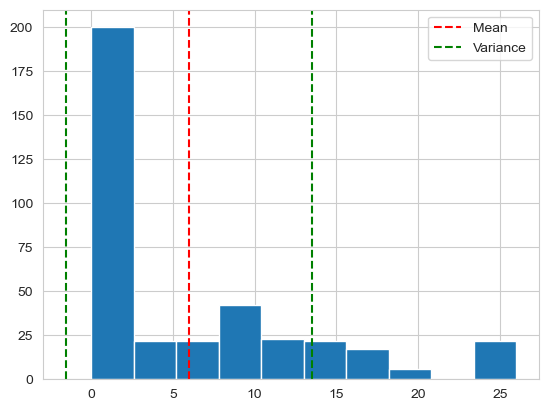

In [10]:
#Calculating the mean and variance for driver points

mean_points = df_races['Points'].mean()
variance_points = df_races['Points'].var()

print("Mean:" + str(mean_points))
print("Variance:" + str(variance_points))

plt.hist(df_races['Points'], bins = 10)
plt.axvline(x=mean_points, color='r', linestyle='--', label='Mean')
plt.axvline(x=mean_points - variance_points ** 0.5, color='g', linestyle='--', label='Variance')
plt.axvline(x=mean_points + variance_points ** 0.5, color='g', linestyle='--')
plt.legend()

Plot a bar chart with Season 2022 Standings for each driver.

Text(0.5, 1.0, 'Season 2022 Standings')

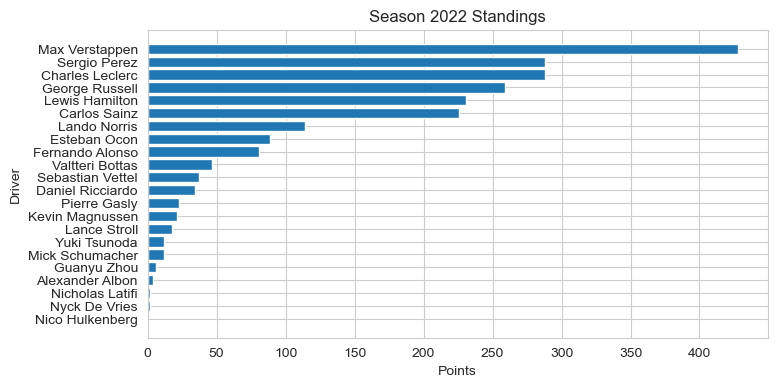

In [11]:
# Sort the dataframe by points in ascending order
driver_points_df = driver_points_df.sort_values('Points', ascending=True)

plt.figure(figsize=(8,4))

# Create a bar chart of the season standings for each driver
plt.barh(driver_points_df['Driver'], driver_points_df['Points'])

# Add labels and title
plt.xlabel('Points')
plt.ylabel('Driver')
plt.title('Season 2022 Standings')

Index the drivers and the teams, and build a python list called drivers_observed that lists all the drivers by index in the order of the df_races dataframe. Finally, build a python list called points_observed that represents the points awarded to each car finishing in the order of the df_races dataframe.

In [12]:
# Get unique drivers and teams from the df_races

drivers = df_races['Driver'].unique()
constructors = df_races['Team'].unique()

# Initialize empty lists to store the observed drivers_observed, constructors_observed, and points_observed

drivers_observed = []
constructors_observed = []
points_observed = []

# Iterate over the rows of the df_races and append the driver, team, and points for each car
for i, row in df_races.iterrows():
    driver = row['Driver']
    team = row['Team']
    points = row['Points']
    drivers_observed.append(list(drivers).index(driver))
    constructors_observed.append(list(constructors).index(team))
    points_observed.append(points)

print("Printing drivers_observed:\n")
print(drivers_observed)
print(" ")
print("Printing constructors_observed:\n")
print(constructors_observed)
print(" ")
print("Printing points_observed: \n")
print(points_observed)

Printing drivers_observed:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 0, 1, 17, 3, 6, 14, 19, 4, 2, 9, 16, 11, 12, 0, 17, 3, 2, 14, 13, 6, 5, 19, 12, 9, 11, 10, 4, 7, 15, 8, 18, 17, 14, 3, 5, 0, 7, 20, 4, 11, 12, 19, 2, 6, 9, 15, 10, 13, 18, 0, 1, 17, 3, 2, 5, 6, 12, 11, 8, 7, 13, 15, 10, 4, 20, 18, 17, 3, 1, 2, 5, 6, 14, 8, 7, 20, 13, 19, 10, 11, 15, 4, 12, 17, 1, 18, 0, 3, 14, 8, 2, 5, 20, 19, 6, 13, 11, 15, 9, 7, 18, 17, 3, 2, 19, 20, 8, 13, 14, 6, 5, 12, 7, 10, 15, 11, 18, 1, 2, 3, 0, 6, 5, 9, 8, 11, 13, 20, 12, 19, 14, 15, 4, 1, 17, 2, 0, 8, 14, 18, 10, 20, 4, 11, 15, 13, 7, 0, 18, 2, 3, 6, 10, 14, 4, 13, 8, 5, 12, 11, 9, 19, 7, 20, 18, 2, 3, 17, 1, 8, 14, 6, 13, 11, 20, 19, 12, 5, 10, 9, 18, 2, 3, 1, 17, 0, 14, 8, 6, 20, 11, 19, 9, 10, 13, 4, 12, 15, 7, 5, 18, 17, 1, 3, 8, 0, 6, 20, 19, 12, 11, 14, 7, 9, 13, 4, 10, 15, 18, 3, 0, 2, 17, 8, 14, 1, 6, 11, 19, 12, 10, 20, 4, 9, 13, 15, 18, 0, 3, 1, 2, 17, 14, 19, 21, 9, 6, 10, 5, 7, 15, 4, 17, 0, 1, 14, 1

In [13]:
print("Names of all drivers:\n")
print(drivers)
print("  ")
print("Names of all constructors:\n")
print(constructors)

Names of all drivers:

['Charles Leclerc' 'Carlos Sainz' 'Lewis Hamilton' 'George Russell'
 'Kevin Magnussen' 'Valtteri Bottas' 'Esteban Ocon' 'Yuki Tsunoda'
 'Fernando Alonso' 'Guanyu Zhou' 'Mick Schumacher' 'Lance Stroll'
 'Alexander Albon' 'Daniel Ricciardo' 'Lando Norris' 'Nicholas Latifi'
 'Nico Hulkenberg' 'Sergio Perez' 'Max Verstappen' 'Pierre Gasly'
 'Sebastian Vettel' 'Nyck De Vries']
  
Names of all constructors:

['Ferrari' 'Mercedes' 'Haas Ferrari' 'Alfa Romeo Ferrari' 'Alpine Renault'
 'AlphaTauri RBPT' 'Aston Martin Aramco Mercedes' 'Williams Mercedes'
 'McLaren Mercedes' 'Red Bull Racing RBPT']


## Building a Bayesian Power Model

We know that a **count outcome** is modelled as a **Poisson distribution**, unless mean and standard deviation really diverge, in which case we use the **negative binomial**. 

Modeling car strength is usually accomplished with a vector of points scored $y$ as a Poisson distributions: $(y_i\;|\;θ_j) \propto Poisson(θ_j)$ where the $\theta_j$ parameters represent the Poisson **expectation** for the car finishing the race.

We will follow the approach of the research paper, simplifying it a bit, and model the point expectation $\theta$ of each car as an exponential of *two* independent variables: a drivers variable **drv**, and a constructor variable **csr**, times a constant factor k:

$$θ_c = k_c * e^{\text{drv}_c} * e^{\text{csr}_c}$$

Instead of 4 (in the paper) where the other two parameters are longer-term effects related to the *experience* of each team *across* seasons. 

>**Note**: Exponential, professor? I thought we were building **linear models**!

Yes, we use an exponential to increase the effect of each indendent variable,  but we will use $log(\theta)$ to simplify to a linear model!

Parameters are initially modeled with a log-linear random effect model, a standard procedure in sports analytics.

$$\log(θ) = log(k) + \text{drv}_c + \text{csr}_c $$

>**Note**: Wait, where's the $x$? There really ***is no $x$***! So we don't really have a linear model, here. Instead, we have an **additive model**, and we create two *new* columns: $\text{att}_g$ and $\text{def}_g$.

Let's assume results are determined jointly by a ***driver*** and ***constructor*** ability for each event, an aggregation of the talent of drivers and mechanics, represented by parameters `drv` and `csr`, respectively.

For each car race result $c = 1, \cdots, C$, car-specific `drv` and `csr` effects will be modelled by a common normal distribution:
$drv_c \propto \text{Normal}(μ_{drv},τ_{drv})$ and $csr_c \propto \text{Normal}(μ_{csr}, τ_{csr})$.

We will initialize $μ_{drv}$ and $μ_{csr}$ to 0, which is a common action in mcmc sims for modeling likelihood parameter pdfs.

As for $\sigma_{drv}$ and $\sigma_{csr}$, we will initialize them to... *another pdf*! This gives the mcmc engine more leeway in the simulation. We will initialize them to half-Student-t distributions. The half-Student-t parameters will be set to match the data's.

We will build our model in `PyMC3`, specifying global parameters, car-specific parameters, and the likelihood function.

Ok, so the data we want to consider are the points awarded for each car in `df_races`.

# 4. Priors
The number of points scored for the entire season, divided by the number of races is a good indicator of both ***driver talent*** and ***constructor know-how***.

So, these will be our priors for the `drv` and `csr` parameters for each car: 

Take the floor of the mean number of points for 2022 per driver, and then its logarithm. It should look like this:
```
Driver
Max Verstappen      6.059123
Charles Leclerc     5.662960
Sergio Perez        5.662960
....
```

Replace infinities with zeros.

Build a python list called `drv_starting_points` that represents these values, in the order of your driver index.

Take the floor of the mean number of points for 2022 per constructor, and then its logarithm. 

Build a python list called `csr_starting_points` that represents these values, in the order of your team index.

These will be our priors for our sim,

In [14]:
import math

#Build a python list called `drv_starting_points` that represents these values, in the order of your driver index.

#Initializing array
drv_starting_points = []

# Calculating mean of team points and then taking the floor of the mean number of points,followed by log of the value
points_by_driver = df_races.groupby('Driver')['Points'].sum().reset_index()
log_mean_points_df = points_by_driver.groupby('Driver')['Points'].mean().apply(lambda x: math.log(x) if x > 0 else 0).reset_index()

#Storing values in an array
for ind in log_mean_points_df.index:
    drv_starting_points.append(log_mean_points_df['Points'][ind])

print("List of drv_starting_points:\n")
print(drv_starting_points)
print(" ")

#Build a python list called `csr_starting_points` that represents these values, in the order of your team index.

#Initializing array
csr_starting_points = []

# Calculating mean of team points and then taking the floor of the mean number of points,followed by log of the value
points_by_team = df_races.groupby('Team')['Points'].sum().reset_index()
log_mean_points_df_team = points_by_team.groupby('Team')['Points'].mean().apply(lambda x: math.log(x) if x > 0 else 0).reset_index()

#Storing values in an array
for ind in log_mean_points_df_team.index:
    csr_starting_points.append(log_mean_points_df_team['Points'][ind])
        
print("List of csr_starting_points:\n")
print(csr_starting_points)


List of drv_starting_points:

[1.3862943611198906, 5.429345628954441, 5.673323267171493, 3.5263605246161616, 4.48863636973214, 4.394449154672439, 5.568344503761097, 1.791759469228055, 3.044522437723423, 2.8903717578961645, 4.7535901911063645, 5.4510384535657, 6.07073772800249, 2.4849066497880004, 0.6931471805599453, 0.0, 0.6931471805599453, 3.1354942159291497, 3.6109179126442243, 5.673323267171493, 3.8501476017100584, 2.4849066497880004]
 
List of csr_starting_points:

[3.970291913552122, 3.5553480614894135, 5.135798437050262, 4.007333185232471, 6.251903883165888, 3.4965075614664802, 5.0106352940962555, 6.20455776256869, 6.584791392385716, 2.0794415416798357]


# 5. Likelihood function and model parameters
Now let's specity our **likelihood function** in `pymc3`. 

A bit of theory:

You should know that whenever we have a small number of data point (about 30 or less), the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) gives better results than the normal distribution. 

If you are modeling the distribution of a *large* population, then use the **normal distribution**. If you are modeling the mean of the population when the population size is small, better to use the **student-t distribution**.

The student-t distribution has higher kurtosis (4th *moment*) than the normal distribution. That means that data from the t-distribution will have a tendency to appear closer or farther from the mean (it's like it says on your rear-view mirror: ***objects are closer than they appear***) than typical normal data, with a more sudden transition in between. In other words, the t-distribution is more *fat-tailed* and captures outliers ***better***: The probability of obtaining values far from the mean is larger than with the normal distribution.

As the number of degrees of freedom of data ($\nu$) increases, the t-distribution becomes closer to the normal distribution. The t-distribution is used a lot in [fintech](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-7701-4_18). Financial data does tend to have higher kurtosis than the normal distribution, and exhibits wild jumps up or down  more frequently than what the normal distribution predicts.

The **half-t distribution** (also denoted **folded-t**) is derived from the t-distribution by taking the absolute values of variates. Since we have positive points, we don't want any negative signs.

But we're not going to use neither the gaussian nor the Student-t as our data likelihood. We are going to use the Poisson distribution, because we have *count* data.

Since we decided on a linear model for log$\theta$, we usually have a *slope-intercept* formula: $y = log(\theta) = mx + b$ where $m$ is the slope or the consistent change between $x$ and $y = log(\theta)$, and $b$ is the y-intercept (intercepts the y-axis at $y = b$). It is the expected mean value of $y$ when $x = 0$. Now, what is $x$? $x$ is the keys, and here we have discrete keys: drivers and constructors. Linear models are most often used with continuous keys. Here, since we have discrete keys, instead of a linear model we are going to use an **additive model**, where $log(\theta)$ can be expressed as the sum of two variables, each modeled as a stochastic distribution.

So here's the model and likelihood in `pymc3`, starting from the bottom of the cell below, to the top:

- The points scored by cars, our **data likelihoods**, will be modelled by Poisson distributions. The Poisson distribution has a single parameter: its **Expectation**, which we will model with a **bivariate linear model** with the two features being ***driver talent*** and ***constructor talent***. 

- Actually, we will compute with the **log** of the expectation, so to make the log of the expectation a linear model, we will assume that the expectation is actually an **exponential**, with an additive model for the exponent.

- Since driver talent and constructor know-how are relative concepts, we will model these strengths as ***car-specific strengths minus the average across all cars***. Note that we are using an additive relational. We also could have used a multiplicative relation whereby talents and know-how are the *ratio* of car-specific values, normalized by the average across all cars.

- The car-specific driver and constructor strenghts (talent and know-how) are parameters of our data likelihood, so we need to model them as probability density functions. What to pick? When we don't know, we pick **normal distributions**! How about their mean and standard deviation?

- Bayesian estimation usually assumes a 0 mean for these parameters. For the standard deviation (noise) we will use a half-normal. But to account for many possible outliers (liek Ferrari in 2022 that made a ton of [strategic mistakes](https://www.gpblog.com/en/news/163001/numerous-mistakes-by-ferrari-in-2022-show-it-was-time-for-binotto-exit.html)), we will use a **half-student-T** instead (noise is never negative, that's why a **half** profile). The student-T has 3 parameters itself, and here we select numbers: Pure guesses (mean 0, sd of 2.5, and a nu of 3).

- The intercept is completely unknown, so we select a **uniform distribution** (all values equally likely)

If you have no idea about the intercept, you could model it with a uniform distribution:
```
    intercept = pm.Flat('intercept') #flat pdf is uninformative - means we have no idea
```

Your car-specific model parameters, specifically one `(drvs_star, csrs_star)` tuple per car, could be modeled with normal distributions (you will need to replace the `?`s. Hint: use your priors!):
```
    drvs_star = pm.Normal("drvs_star", mu=0, sd=?, shape=?)
    csrs_star = pm.Normal("csrs_star", mu=0, sd=?, shape=?)
```

To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects. Since we only care about *relative* strengths, we subtract from `drvs_star` and `csrs_star` the mean across drivers and constructors. We save these parameters for later exploration:
```
    drvs = pm.Deterministic('drvs', drvs_star - tt.mean(drvs_star))
    csrs = pm.Deterministic('csrs', csrs_star - tt.mean(csrs_star))
```

Assume an exponential search on the theta parameter:
```
    theta = tt.exp(intercept + drvs[drivers_observed] + csrs[constructors_observed])  
```

Assume a Poisson likelihood on the observed data (Points) with expectation `theta`:
```
    points = pm.Poisson('points', mu=theta, observed=points_observed)
```

Note that if you don't have `theano`, you could replace `tt.exp` with `pm.math.exp` and `tt.mean` with `pm.math.sum(..)/num_teams`. 

If you opted for pymc 5.1.1, you already have `pytensor` installed and you can replace `theano` with `pytensor`.

In [15]:
from pymc3 import Model, HalfStudentT

with Model() as F1_model:
    
    # define an intercept parameter with a flat prior
    intercept = pm.Flat('intercept') 
    
    # set the means of the driver and constructor groups to zero
    mu_d = 0 
    mu_c = 0 

    # define the prior distributions for the standard deviations of the driver and constructor groups
    tau_d = HalfStudentT('tau_d', nu=3, sigma=2.5) 
    tau_c = HalfStudentT('tau_c', nu=3, sigma=2.5)
    
    # create a normal distribution for each group, using the specified priors for their standard deviations
    # the length of each group is determined by the length of the corresponding starting points array
    drvs_star = pm.Normal("drvs_star", mu=mu_d, sd=tau_d, shape= len(drv_starting_points)) 
    csrs_star = pm.Normal("csrs_star", mu=mu_c, sd=tau_c, shape= len(csr_starting_points))
    
    # create deterministic variables for the centered versions of the driver and constructor groups
    drvs = pm.Deterministic('drvs', drvs_star - tt.mean(drvs_star))
    csrs = pm.Deterministic('csrs', csrs_star - tt.mean(csrs_star))

In [16]:
with F1_model:
    theta = tt.exp(intercept + drvs[drivers_observed] + csrs[constructors_observed])

In [17]:
with F1_model:
    points = pm.Poisson('points', mu=theta, observed=points_observed)

# 6. Simulation
Run the mcmc simulation and plot the traces for your model parameters (You may have to replace `pm.traceplot()` with `pm.plot_trace`).

```
    trace = pm.sample(5000, tune=1000, cores=1)
    pm.traceplot(trace)
```

Then, tabulate your model parameters:
```
import arviz as az
az.summary(trace, round_to=2)
```

/Users/keerthanaakannan/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [csrs_star, drvs_star, tau_c, tau_d, intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 106 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/2985582636.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


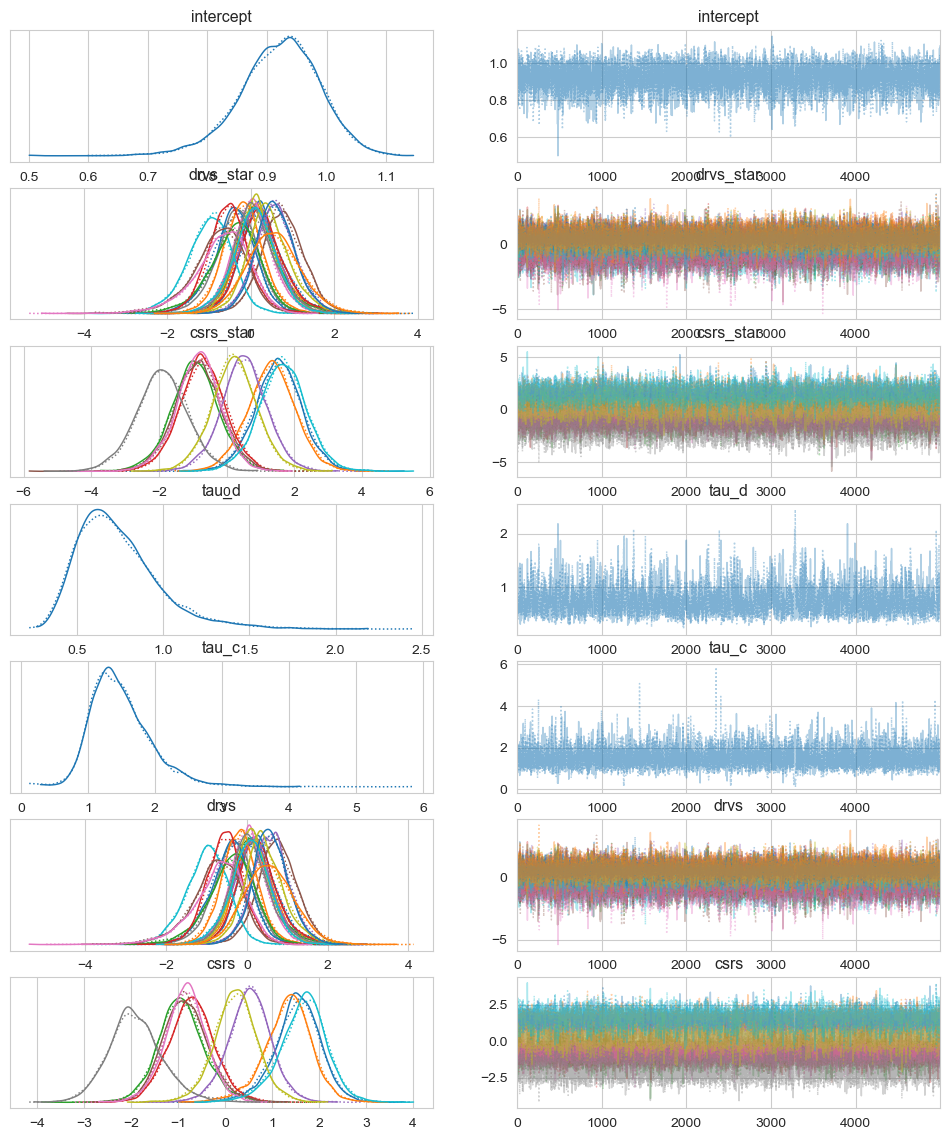

In [18]:
#Running the mcmc simulation and ploting the traces for your model parameters

with F1_model:
    trace = pm.sample(5000, tune=1000, cores=1)
    pm.traceplot(trace)

In [19]:
#Tabulating model parameters

import arviz as az
az.summary(trace, round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/keerthanaakannan/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.92,0.07,0.80,1.05,0.00,0.00,6932.51,5721.67,1.0
drvs_star[0],0.28,0.56,-0.73,1.39,0.01,0.01,4701.05,2658.10,1.0
drvs_star[1],0.21,0.56,-0.79,1.33,0.01,0.01,4806.91,2520.98,1.0
drvs_star[2],0.16,0.56,-0.86,1.26,0.01,0.01,5544.59,3314.44,1.0
drvs_star[3],0.28,0.56,-0.79,1.34,0.01,0.01,5384.74,3059.39,1.0
...,...,...,...,...,...,...,...,...,...
csrs[5],-0.84,0.50,-1.75,0.11,0.01,0.00,7449.08,5253.14,1.0
csrs[6],-0.84,0.46,-1.72,-0.00,0.01,0.00,6958.92,5189.06,1.0
csrs[7],-1.90,0.59,-2.98,-0.75,0.01,0.01,4969.17,2686.55,1.0
csrs[8],0.22,0.47,-0.68,1.11,0.01,0.00,8555.89,6349.68,1.0


# 7. Setting a hypothetical constraint
Let's set a constraint that Charles Leclerc (Ferrari) is a better driver than Max Verstappen (Red Bull). How much better does The Red Bull constructor need to be in order to justify this constraint?

Provide this answer in a percentage relative to Ferrari and Mercedes.

A `pm.Potential()` is an arbitrary factor that you can add to the model likelihood. In this example, by using `tt.switch()`, if the parameters satisfies you constraints in `tt.switch`, we add nothing to the model, otherwise we add `-inf` to the log-likelihood of the model, making it *impossible*.

Let's set a constraint that Charles Leclerc (Ferrari) is a better driver than Max Verstappen (Red Bull)
```
    pm.Potential('CL_>_MV', tt.switch( tt.mean(drvs_star[1]) > tt.mean(drvs_star[0]), 0., -np.inf))
```

You may replace the `tt.switch` API on setting a simulation constraint to `pm.math.switch`.

Then, run the sim again. Note that you may have to limit it to 1 chain due to numerical instabilities (simulation blows up with `Bad initial energy`). You will get a *lot* of divergences with the constraint, representing cases where the constraint is *not* fulfilled and thus sampled off.
```
`trace = pm.sample(5000, tune=1000, cores=1, chains=1)
```

Conclude.

charles leclerc - 0
Max Verstappen - 18

Ferrari - 0
Red Bull - 9
Mercedes - 1

In [31]:
from pymc3 import Model, HalfStudentT

with Model() as F1_model_constraint:
    
    # define an intercept parameter with a flat prior
    intercept = pm.Flat('intercept')
    
    # set the means of the driver and constructor groups to zero
    mu_d = 0
    mu_c = 0

    # define the prior distributions for the standard deviations of the driver and constructor groups
    tau_d = HalfStudentT('tau_d', nu=3, sigma=2.5)
    tau_c = HalfStudentT('tau_c', nu=3, sigma=2.5)   

    # create a normal distribution for each group, using the specified priors for their standard deviations
    # the length of each group is determined by the length of the corresponding starting points array    
    drvs_star = pm.Normal("drvs_star", mu=mu_d, sd=tau_d, shape= len(drv_starting_points)) #0.2 #0.6
    csrs_star = pm.Normal("csrs_star", mu=mu_c, sd=tau_c, shape= len(csr_starting_points))

    # create deterministic variables for the centered versions of the driver and constructor groups    
    drvs = pm.Deterministic('drvs', drvs_star - tt.mean(drvs_star)) 
    csrs = pm.Deterministic('csrs', csrs_star - tt.mean(csrs_star)) 
    
    theta = tt.exp(intercept + drvs[drivers_observed] + csrs[constructors_observed])
    points = pm.Poisson('points', mu=theta, observed=points_observed)
    
    # 0 position is Charles and 18th position is Max
    # Setting a constraint Charles Leclerc (Ferrari) is a better driver than Max Verstappen (Red Bull)
    pm.Potential('CL_>_MV', tt.switch( tt.mean(drvs_star[0]) > tt.mean(drvs_star[18]), 0., -np.inf))

In [32]:
with F1_model_constraint:
    trace_new = pm.sample(5000, tune=1000, cores=1, chains=1)

/Users/keerthanaakannan/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [csrs_star, drvs_star, tau_c, tau_d, intercept]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 25 seconds.
There were 4711 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/1619529830.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_new)


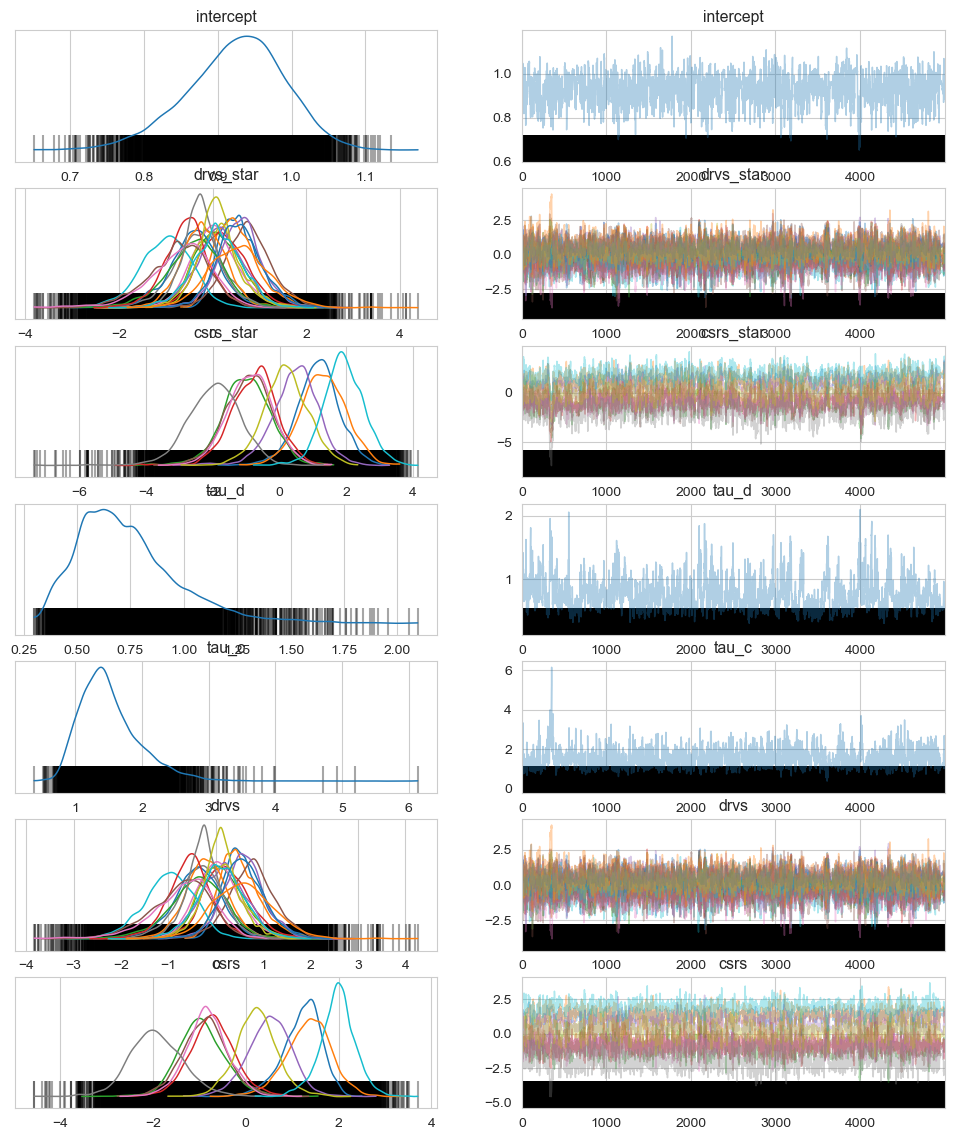

In [33]:
with F1_model_constraint:
    pm.traceplot(trace_new)

Q. How much better does The Red Bull constructor need to be in order to justify this constraint? Provide this answer in a percentage relative to Ferrari and Mercedes.

To solve this, we will first need to calculate total CSRs for Ferrari and Mercedes by taking the average of their respective CSRs. Then we, calculate the relative performance of Red Bull and Ferrari, by subtracting the average CSR for Ferrari-Mercedes from the CSRs for Red Bull and Ferrari, respectively.

Further, we use numpy's mean function to calculate the percentage of values in each array that are positive. This gives the percentage of races in which Red Bull and Ferrari performed better than Ferrari-Mercedes.

Then, we calculate the percentage of races in which Red Bull needs to perform better than Ferrari to beat them overall in the season. This is done by subtracting the 'redbull_relative' array from the 'ferrari_relative' array, which gives the difference in performance between the two teams. The numpy mean function is then used again to calculate the percentage of races in which this difference is positive. This gives the percentage of races in which Red Bull needs to improve its performance relative to Ferrari to beat them overall in the season.

In [35]:
# Getting the mean of Ferrari and Mercedes because we need to find the answer in a percentage relative to Ferrari and Mercedes.
f_m_total = (trace_new['csrs_star'][:,0] + trace_new['csrs_star'][:,1])/2

#Calculating relative value of redubll, if relative value of redbull_relative is +ve redbull is better than ferrari_mercedes_total
r_relative = trace_new['csrs_star'][:,9] - f_m_total

#Calculating relative value of ferrari, if relative value of ferrari_relative is +ve ferrari is better than ferrari_mercedes_total
f_relative = trace_new['csrs_star'][:,0] - f_m_total

r_better = np.mean(r_relative > 0) * 100
print('Redbull is better than Ferrari and Mercedes by '+ str(r_better)+'%\n')

f_better = np.mean(f_relative > 0) * 100
print('Ferrari is better than Ferrari and Mercedes by '+ str(f_better)+'%\n')

#Getting cases where redbull is loosing and needs to improve
#We only consider cases where redbull is performing poorer than ferrari 
#i.e., ferrari>redbull
ferrari_redbull = [r_relative[i] - f_relative[i] for i in range(len(f_relative)) if f_relative[i] < r_relative[i]]
f_r_better = np.mean(ferrari_redbull) * 100

print("Redbull is better by: " + str(f_r_better) +'%')

Redbull is better than Ferrari and Mercedes by 97.26%

Ferrari is better than Ferrari and Mercedes by 42.34%

Redbull is better by: 77.34952715232886%


<b>Thus to justify the above constraint that Charles Leclerc (Ferrari) is a better driver than Max Verstappen (Red Bull), we would want to give them constructors with similar strengths. Hence, to compare and hold this constraint true Redbull should be worse by 77% more.

# 8. Plots

From model posteriors, plot driver talent *and* constructor strength with *and* without the constraint above, *with* **credible intervals**, so you have uncertainty quantification of your estimate of cars' strengths.

For example, your plot for driver talent should look like this (I removed the names of the drivers on the x-axis):

<br />
<center>
<img src="ipynb.images/driver_strength_unknown.png" width=600 />
</center>

In Bayesian statistics, a **credible interval** is a range of values within which an unobserved parameter value falls with a particular subjective probability. It is an interval in the domain of a posterior probability distribution or a predictive distribution.

Credible intervals are analogous to **confidence intervals** in frequentist statistics we studied when we studied the t-test?

Bayesian intervals treat bounds as *fixed* and the estimated parameter as a *random variable*. In our experiment to determine the distribution of team strength `att`, if the subjective probability that `att`$_{germany}$ lies between 0.35 and 0.55 is 0.95, then $0.35\leq \text{att} \leq 0.55$ is a 95% credible interval.

Frequentist confidence intervals treat bounds as random variables and the parameter as a fixed value. A frequentist 95% confidence interval means that with a large number of repeated samples, 95% of such calculated confidence intervals would include the true value of the parameter. Aren't Bayesian credible intervals a much better metric? I think they are. However, Bayesian credible intervals do require knowledge of a situation-specific prior distribution, while frequentist confidence intervals do not.

The **highest posterior density interval** (HDI) is the interval which contains the required point estimate such that all points within the interval have a higher probability density than points outside the interval. The HDI is the narrowest interval containing the specified point estimate. Locating the HDI is usually accomplished using the Chen-Shao algorithm (Chen and Shao; 1999; Chen, Shao, and Ibrahim; 2000). For more info, this is the best [reference](https://cran.r-project.org/web/packages/HDInterval/HDInterval.pdf) i've found. In `pymc3`, you get it with `pm.stats.hpd`.

**Quantiles** are sets of values of a variate that divide a frequency distribution into equal groups, each containing the same fraction of the total population. The *Median* is an example of a quantile that separates the two halves of a group.

Then, plot posterior pdfs for all drivers and for all constructors.

/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/165197672.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  driver_talent_hpd = az.hdi(driver_talent, hdi_prob=0.95)
/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/165197672.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot((x, x), (lower, upper), 'r-', color='blue')


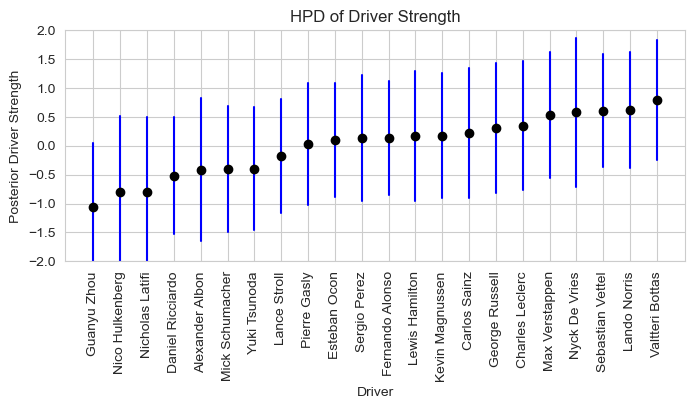

In [36]:
# WITHOUT CONSTRAINT DRIVER TALENT

driver_talent = trace['drvs_star']

# Calculate the HPD of the 'driver_talent' data with a 95% probability
driver_talent_hpd = az.hdi(driver_talent, hdi_prob=0.95)

# Initialize data_dict and add lower_list,upper_list and category
data_dict = {}
data_dict['lower_list'] = list(driver_talent_hpd[:,0])
data_dict['upper_list'] = list(driver_talent_hpd[:,1])
data_dict['category'] = list(drivers)

dataset = pd.DataFrame(data_dict)

dataset['mean'] = (dataset['lower_list'] + dataset['upper_list']) / 2  # calculate mean of lower and upper bounds
dataset = dataset.sort_values('mean', ascending= True)  # sort by mean in descending order

fig, ax = plt.subplots(figsize=(8, 3))

for lower, upper, x in zip(dataset['lower_list'], dataset['upper_list'], range(len(dataset))):
    center = (lower + upper) / 2
    ax.plot((x, x), (lower, upper), 'r-', color='blue')
    ax.plot(x, center, marker='o', color='black')
    
ax.set_xticks(range(len(dataset)))
ax.set_xticklabels(list(dataset['category']))
ax.invert_yaxis()  # invert the y-axis
ax.set_title('HPD of Driver Strength')
ax.set_xlabel('Driver')
ax.set_ylabel('Posterior Driver Strength')
plt.xticks(rotation=90)
ax.set_ylim(-2, 2) 

plt.show()


/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/806810630.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  driver_talent_hpd = az.hdi(driver_talent, hdi_prob=0.95)
/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/806810630.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot((x, x), (lower, upper), 'r-', color='blue')


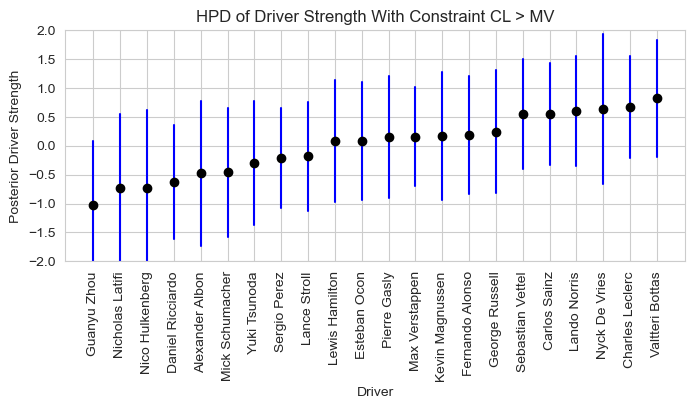

In [37]:
#WITH CONSTRAINT DRIVER TALENT

driver_talent = trace_new['drvs_star']

# Calculate the HPD of the 'driver_talent' data with a 95% probability
driver_talent_hpd = az.hdi(driver_talent, hdi_prob=0.95)

# Initialize data_dict and add lower_list,upper_list and category
data_dict = {}
data_dict['lower_list'] = list(driver_talent_hpd[:,0])
data_dict['upper_list'] = list(driver_talent_hpd[:,1])
data_dict['category'] = list(drivers)

dataset = pd.DataFrame(data_dict)

dataset['mean'] = (dataset['lower_list'] + dataset['upper_list']) / 2  # calculate mean of lower and upper bounds
dataset = dataset.sort_values('mean', ascending= True)  # sort by mean in descending order

fig, ax = plt.subplots(figsize=(8, 3))

for lower, upper, x in zip(dataset['lower_list'], dataset['upper_list'], range(len(dataset))):
    center = (lower + upper) / 2
    ax.plot((x, x), (lower, upper), 'r-', color='blue')
    ax.plot(x, center, marker='o', color='black')
    
ax.set_xticks(range(len(dataset)))
ax.set_xticklabels(list(dataset['category']))
ax.invert_yaxis()  # invert the y-axis
ax.set_title('HPD of Driver Strength With Constraint CL > MV')
ax.set_xlabel('Driver')
ax.set_ylabel('Posterior Driver Strength')
plt.xticks(rotation=90)
ax.set_ylim(-2, 2) 
plt.show()


/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/805627829.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  constructors_talent_hpd = az.hdi(constructors_talent, hdi_prob=0.95)
/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/805627829.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot((x, x), (lower, upper), 'r-', color='blue')


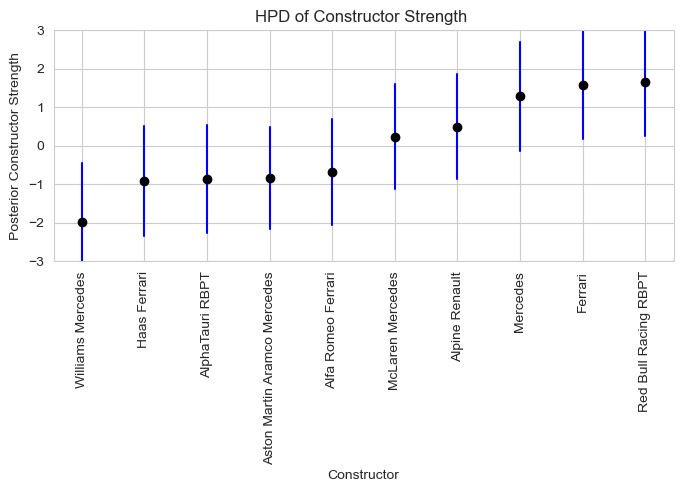

In [38]:
# WITHOUT CONSTRAINT CONSTRUCTOR STRENGTH

constructors_talent = trace['csrs_star']

# Calculate the HPD of the 'driver_talent' data with a 95% probability
constructors_talent_hpd = az.hdi(constructors_talent, hdi_prob=0.95)

# Initialize data_dict and add lower_list,upper_list and category
data_dict = {}
data_dict['lower_list'] = list(constructors_talent_hpd[:,0])
data_dict['upper_list'] = list(constructors_talent_hpd[:,1])
data_dict['category'] = list(constructors)

dataset = pd.DataFrame(data_dict)

dataset['mean'] = (dataset['lower_list'] + dataset['upper_list']) / 2  # calculate mean of lower and upper bounds
dataset = dataset.sort_values('mean', ascending= True)  # sort by mean in ascending order

fig, ax = plt.subplots(figsize=(8, 3))

for lower, upper, x in zip(dataset['lower_list'], dataset['upper_list'], range(len(dataset))):
    center = (lower + upper) / 2
    ax.plot((x, x), (lower, upper), 'r-', color='blue')
    ax.plot(x, center, marker='o', color='black')
    
ax.set_xticks(range(len(dataset)))
ax.set_xticklabels(list(dataset['category']))
ax.invert_yaxis()  # invert the y-axis
ax.set_title('HPD of Constructor Strength ')
ax.set_xlabel('Constructor')
ax.set_ylabel('Posterior Constructor Strength')
plt.xticks(rotation=90)
ax.set_ylim(-3, 3) 
plt.show()


/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/3711318244.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  constructors_talent_hpd = az.hdi(constructors_talent, hdi_prob=0.95)
/var/folders/4w/gzwnglt575713rq2s0x__2_r0000gn/T/ipykernel_66264/3711318244.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot((x, x), (lower, upper), 'r-', color='blue')


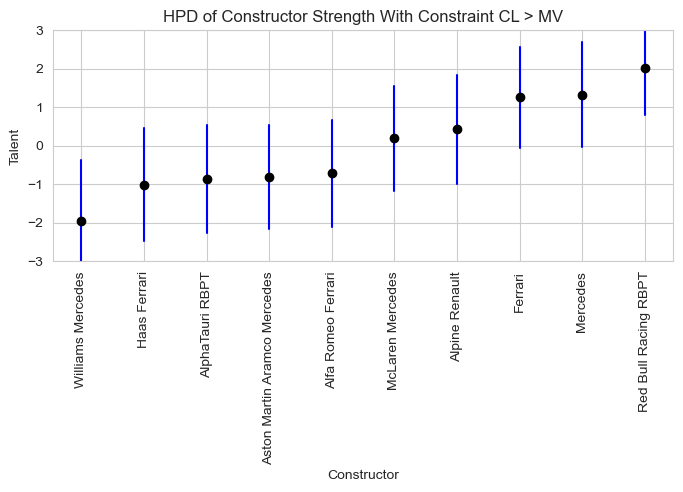

In [39]:
# WITH CONSTRAINT CONSTRUCTOR STRENGTH

constructors_talent = trace_new['csrs_star']

# Calculate the HPD of the 'driver_talent' data with a 95% probability
constructors_talent_hpd = az.hdi(constructors_talent, hdi_prob=0.95)

# Initialize data_dict and add lower_list,upper_list and category
data_dict = {}
data_dict['lower_list'] = list(constructors_talent_hpd[:,0])
data_dict['upper_list'] = list(constructors_talent_hpd[:,1])
data_dict['category'] = list(constructors)

dataset = pd.DataFrame(data_dict)

dataset['mean'] = (dataset['lower_list'] + dataset['upper_list']) / 2  # calculate mean of lower and upper bounds
dataset = dataset.sort_values('mean', ascending= True)  # sort by mean in ascending order

fig, ax = plt.subplots(figsize=(8, 3))

for lower, upper, x in zip(dataset['lower_list'], dataset['upper_list'], range(len(dataset))):
    center = (lower + upper) / 2
    ax.plot((x, x), (lower, upper), 'r-', color='blue')
    ax.plot(x, center, marker='o', color='black')
    
ax.set_xticks(range(len(dataset)))
ax.set_xticklabels(list(dataset['category']))
ax.invert_yaxis()
ax.set_title('HPD of Constructor Strength With Constraint CL > MV')
ax.set_xlabel('Constructor')
ax.set_ylabel('Talent')
plt.xticks(rotation=90)
ax.set_ylim(-3, 3) 

plt.show()


## A note about Red Bull Racing
[Red Bull Racing](https://en.wikipedia.org/wiki/Red_Bull_Racing), also simply known as Red Bull or RBR and currently competing as Oracle Red Bull Racing, is one of two Formula One teams owned by conglomerate Austrian company Red Bull GmbH, the other being Scuderia AlphaTauri (previously Scuderia Toro Rosso).

Red Bull had **Cosworth** engines in 2005 and **Ferrari** engines in 2006. 

The team used engines supplied by **Renault** between 2007 and 2018 (from 2016 to 2018, the Renault engine was re-badged "TAG Heuer" following the breakdown in the relationship between Red Bull and Renault in 2015). During this partnership, they won four successive Drivers' and Constructors' Championship titles from 2010 to 2013, becoming the first Austrian team to win the title. 

The team began using **Honda** engines in 2019. The works Honda partnership culminated in 2021 following Red Bull driver Max Verstappen's World Drivers' Championship victory, with Verstappen also winning the championship in 2022. Honda left the sport officially after 2021, but will continue to supply complete engines from Japan to the team under Red Bull Powertrains branding until the end of 2025.

Starting in 2025, **Ford** will supply the engine, starting with a hybrid (gas/battery) block.

# 9. Validating your model with Posterior Predictive Checks

Comparing the data to **posterior predictions** of the model is called a **posterior predictive check** (PPC). When there appear to be systematic discrepancies that would be meaningful to address, we should consider expanding or changing the model so it may be a better description of the data.

You can read [here](https://www.sciencedirect.com/topics/mathematics/posterior-predictive-check) about Posterior Predictive Checks, and [here](https://www.sciencedirect.com/topics/mathematics/bayesian-model-comparison) about the sensitivity of the Bayes Factor to priors, whenc comparing different models (for example, one model that predicts planetary motions based on elliptical orbits around the sun, as posited by Galileo Galilei, and another that predicts planetary motions based on circular cycles and epicycles around the earth, as posited by the Catholic Church).

Let's do **posterior predictive checks**  in order to validate our model. The idea is to generate data from the model using parameters from draws from the posterior.

PPCs can help analyze the degree to which data generated from the model deviate from data generated from the true distribution. Visualizing the PPC is a great "***sense check***" of your model. In `pymc3`, it's done with `sample_ppc()` of your trace.

Posterior predictive checks are just like a simulation, with the optimal parameters of your model. 

It's like generating new futures from your model, so that you can generate, let's say 100 futures to see what the mean outcome will be.

For example: `ppc = pm.sample_ppc(trace, samples=500, model=f1_model, size=100)` will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 100 random variates from the Poisson distribution specified by the values of the parameters in that sample. 

If one does not specify the `samples` and `size` parameters, then it will draw one random variate from each trace point:
```
pp_trace = pm.sample_posterior_predictive(trace)
```

In [40]:
ppc = pm.sample_posterior_predictive(trace,samples=10000,model = F1_model)

[Text(0.5, 1.0, 'Simulated histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

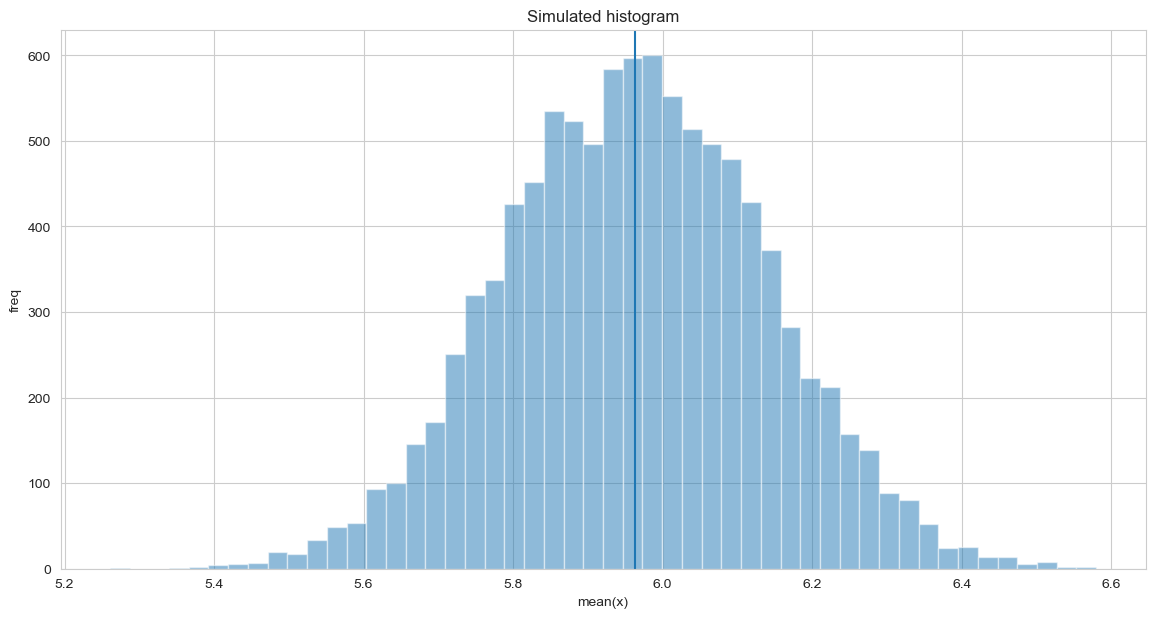

In [41]:
_, ax = plt.subplots(figsize = (14, 7))

ax.hist([n.mean() for n in ppc['points']], bins = 50, alpha = 0.5)
ax.axvline(df_races['Points'].mean())
ax.set(title = 'Simulated histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

[Text(0.5, 1.0, 'Empirical histogram'),
 Text(0.5, 0, 'mean(x)'),
 Text(0, 0.5, 'freq')]

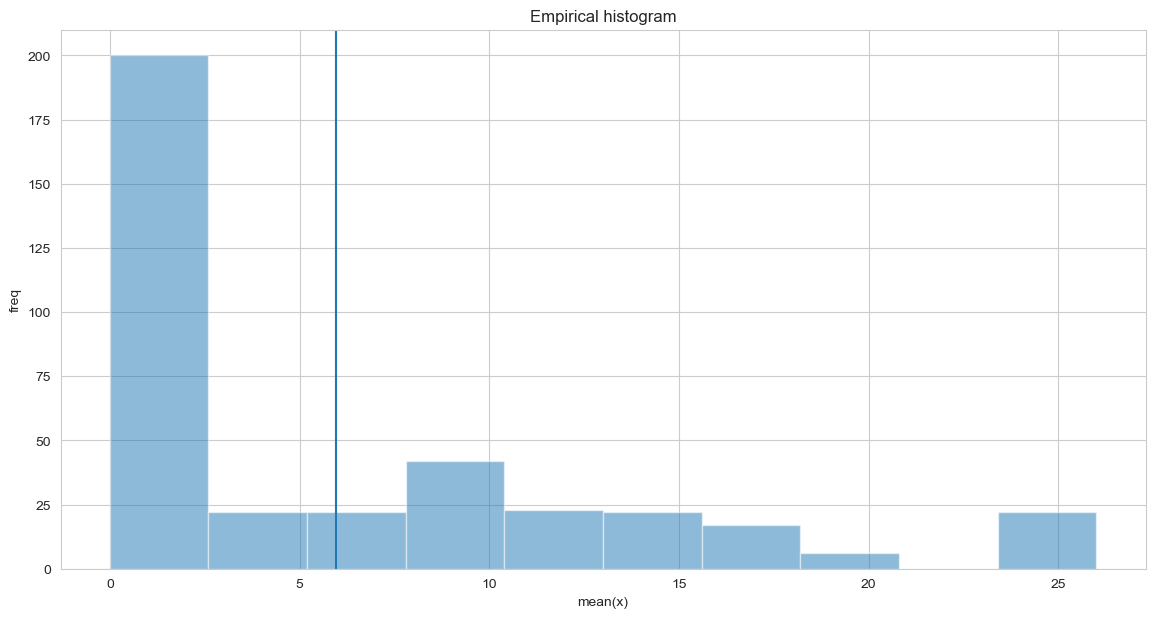

In [42]:
_, ax = plt.subplots(figsize = (14, 7))

plt.hist(df_races['Points'], bins = 10, alpha = 0.5)
ax.axvline(df_races['Points'].mean())
ax.set(title = 'Empirical histogram', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

In [43]:
print("Predictive Mean: " + str(ppc['points'].mean()))
print("Emperical Mean: " + str(df_races['Points'].mean()))

print("\nBoth the Predictive Mean and Emperical Mean are similar, this verifies that our model is correct.")

Predictive Mean: 5.962986968085106
Emperical Mean: 5.962765957446808

Both the Predictive Mean and Emperical Mean are similar, this verifies that our model is correct.


Recall that your original dataset had 440 observations.

So, with your model, generate 10,000 times season 2022 of F1. The observations order for each one of these simulated season is the same as our original data.

Gather all the simulated points and plot the HPD of Driver talent and constructor know-how after 10,000 simulated seasons. Verify that it matches your empirical results.

This is how you can verify that your model is correct.

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/keerthanaakannan/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'drvs_star\n0'}>,
        <AxesSubplot:title={'center':'drvs_star\n1'}>,
        <AxesSubplot:title={'center':'drvs_star\n2'}>,
        <AxesSubplot:title={'center':'drvs_star\n3'}>],
       [<AxesSubplot:title={'center':'drvs_star\n4'}>,
        <AxesSubplot:title={'center':'drvs_star\n5'}>,
        <AxesSubplot:title={'center':'drvs_star\n6'}>,
        <AxesSubplot:title={'center':'drvs_star\n7'}>],
       [<AxesSubplot:title={'center':'drvs_star\n8'}>,
        <AxesSubplot:title={'center':'drvs_star\n9'}>,
        <AxesSubplot:title={'center':'drvs_star\n10'}>,
        <AxesSubplot:title={'center':'drvs_star\n11'}>],
       [<AxesSubplot:title={'center':'drvs_star\n12'}>,
        <AxesSubplot:title={'center':'drvs_star\n13'}>,
        <AxesSubplot:title={'center':'drvs_star\n14'}>,
        <AxesSubplot:title={'center':'drvs_star\n15'}>],
       [<AxesSubplot:title={'center':'drvs_star\n16'}>,
        <AxesSubplot:title={'center':'drvs_star\n17'}>

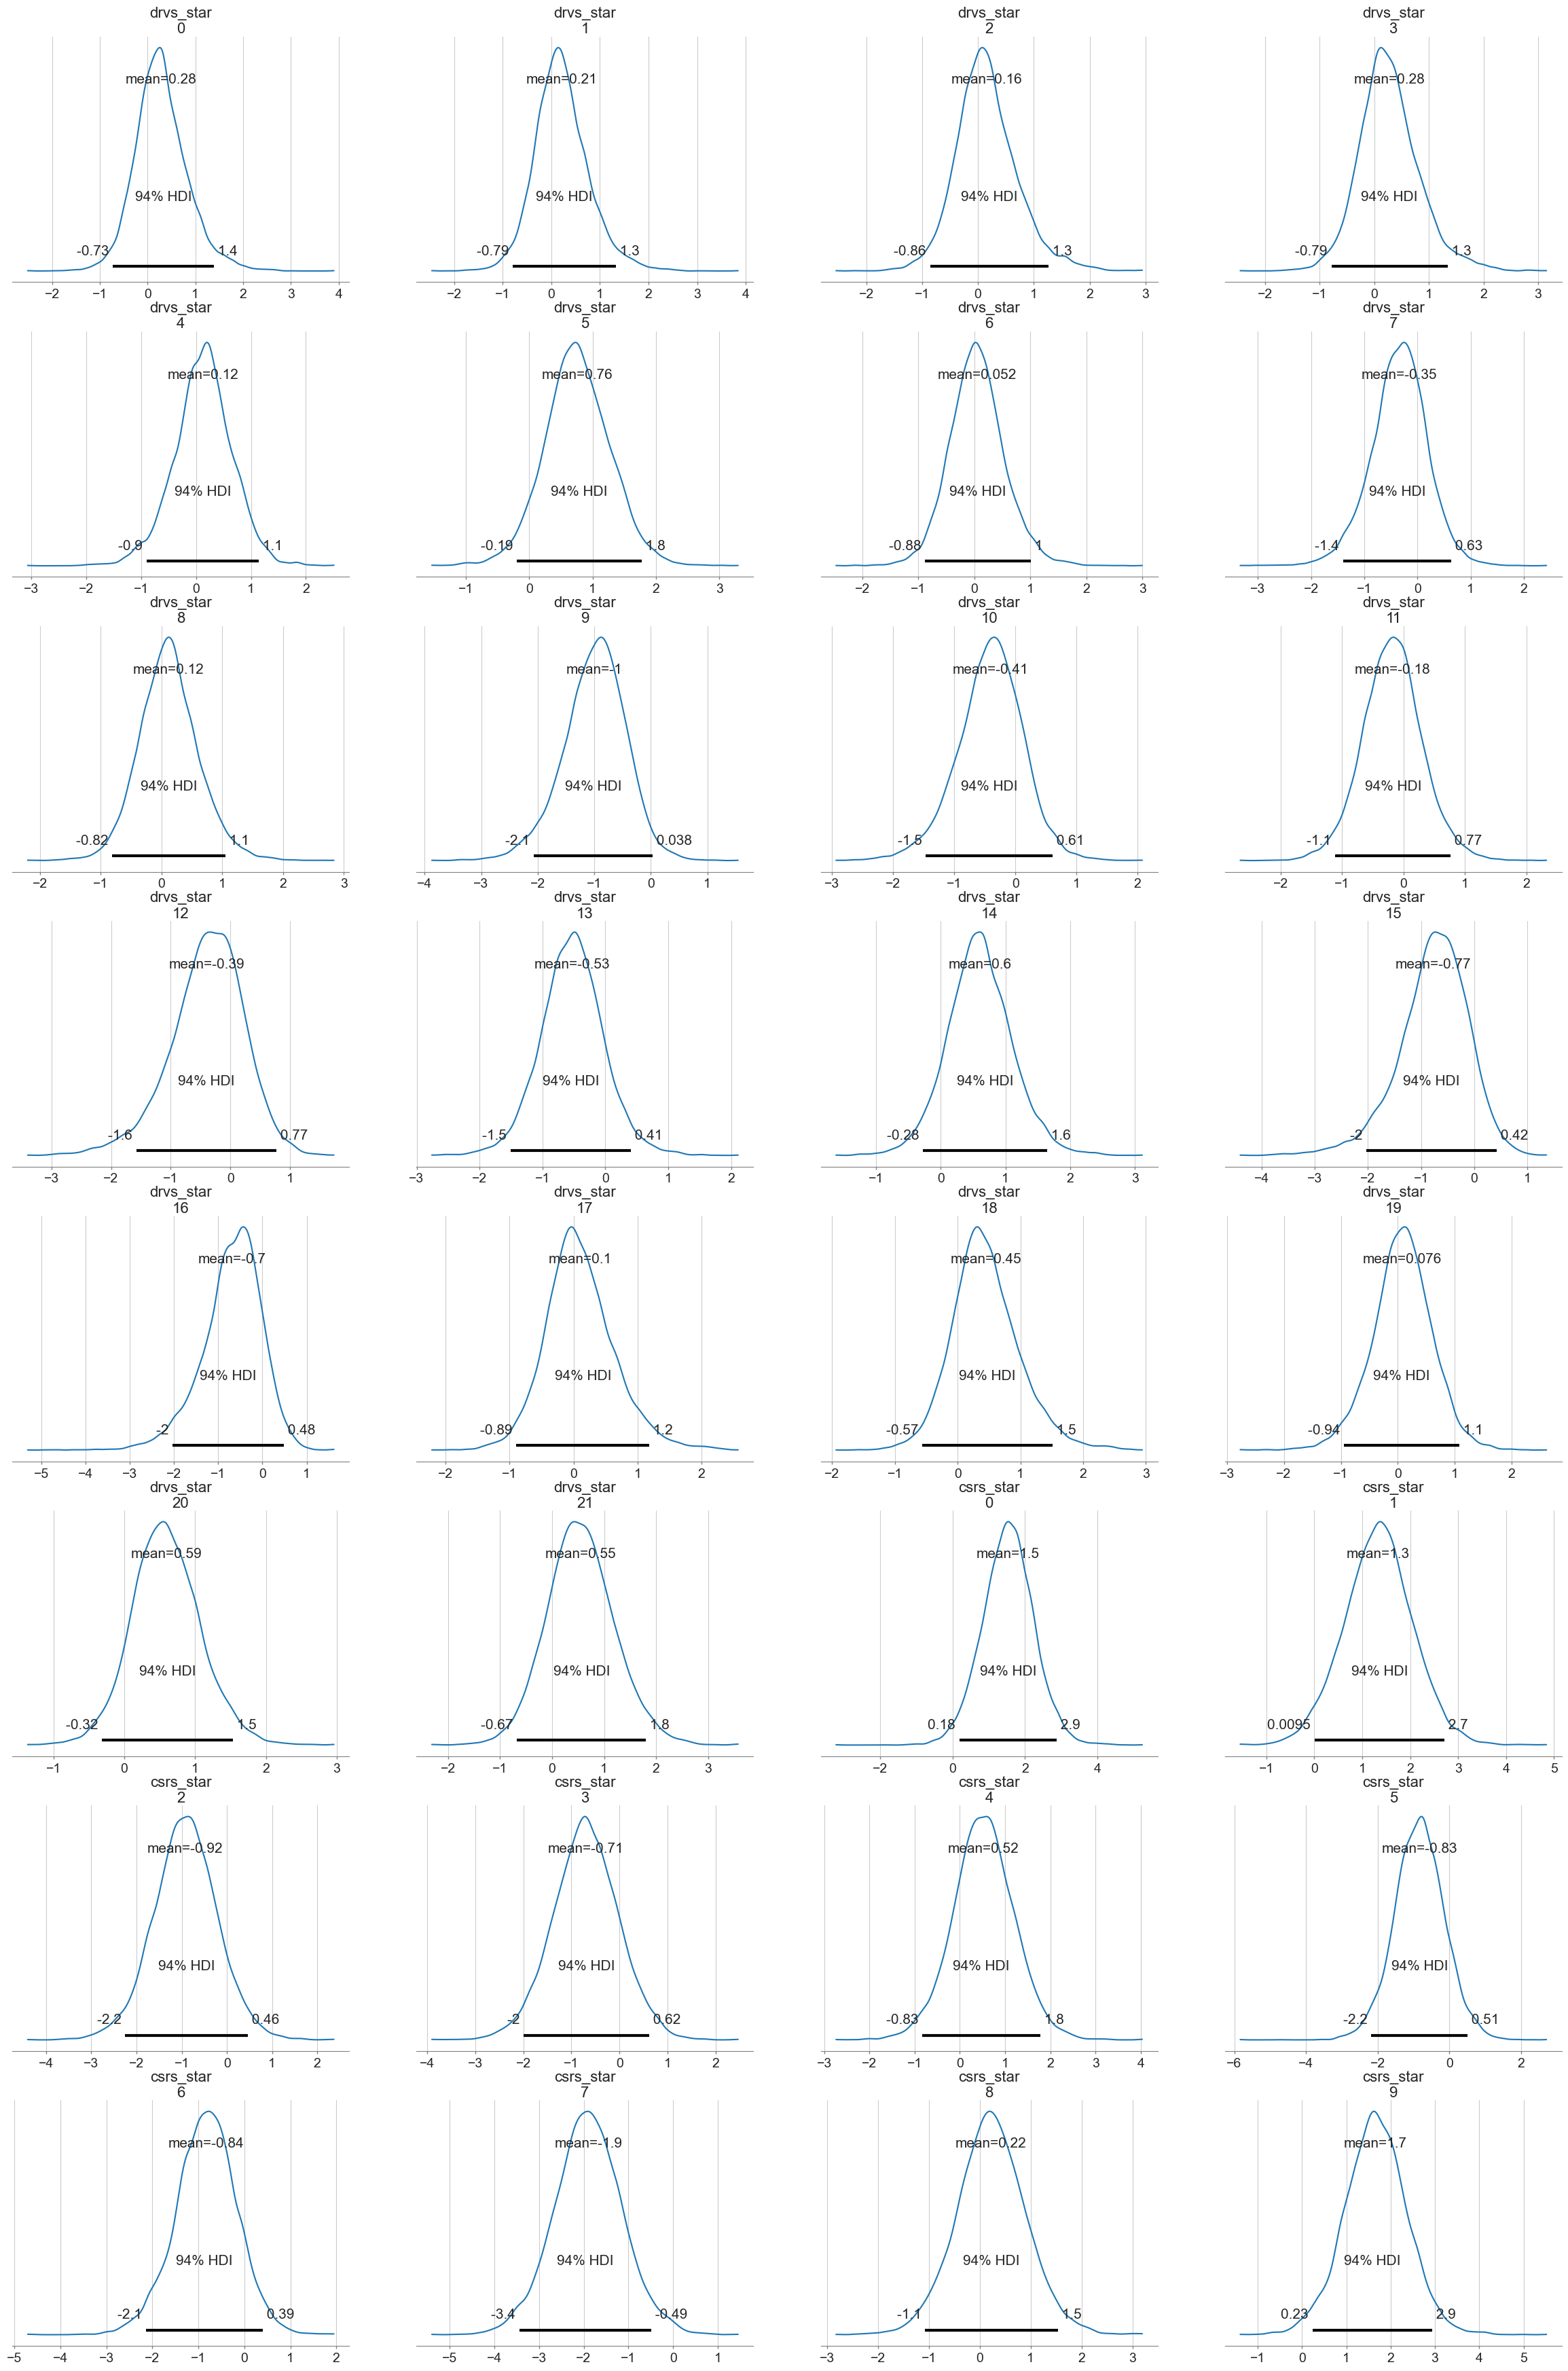

In [44]:
az.plot_posterior(trace, var_names=["drvs_star", "csrs_star"])

In [45]:
ppc['points'][0]

# Append all points into an array - result
result = []
for i in range(len(ppc['points'][0])):
    result.append(0)

# Get the sum of all values for eaach race in simulated data
for ind in range(len(ppc['points'])):
    for i in range(len(ppc['points'][ind])):
        result[i] += ppc['points'][ind][i]

# Find the mean points for each race
result = [x/len(ppc['points']) for x in result]
# print(result)

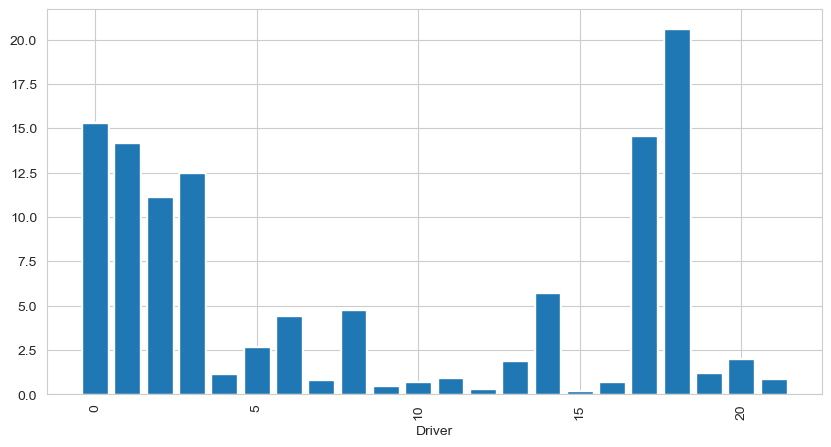

In [46]:
# Create a dictionary to map result with driver
data_dict = {}
data_dict['drivers_observed'] = list(drivers_observed)
data_dict['result'] = list(result)

dataset = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(10, 5))

#Ploting the data
plt.bar(data_dict['drivers_observed'] , data_dict['result'])

# ax.set_xticks(range(len(dataset)))
# ax.set_xticklabels(list(dataset['category']))
# ax.invert_yaxis()  # invert the y-axis
ax.set_xlabel('Driver')
# ax.set_ylabel('Talent')
plt.xticks(rotation=90)

plt.show()

<b>Here we can see that in the simulated data Driver on index 18 has the highest points, that is in the simulated data Max Verstappen is the best. This can also be seen in our original dataset, we can refer the graph - 'Season 2022 standing' plotted above. This verifies that our model is correct.

## The world where CL > MV
In this model, we used a constraint to force Charles Leclerc's talent to be higher than Max Verstappen. 

Generate a posterior predictive distribution to see who wins the season in this world. Keep in mind that in this world, Red Bull racing should have been found to be rated *much higher* than competitors in constructor know-how.

In [47]:
ppc_constraint = pm.sample_posterior_predictive(trace_new,samples=10000,model = F1_model_constraint)

/Users/keerthanaakannan/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1717: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


In [48]:
ppc_constraint['points'][0]

# Append all points into an array - result
result_constraint = []
for i in range(len(ppc_constraint['points'][0])):
    result_constraint.append(0)

# Get the sum of all values for eaach race in simulated data
for ind in range(len(ppc_constraint['points'])):
    for i in range(len(ppc_constraint['points'][ind])):
        result_constraint[i] += ppc_constraint['points'][ind][i]

# Find the mean points for each race
result_constraint = [x/len(ppc_constraint['points']) for x in result_constraint]
# print(len(result_constraint))
# result_constraint

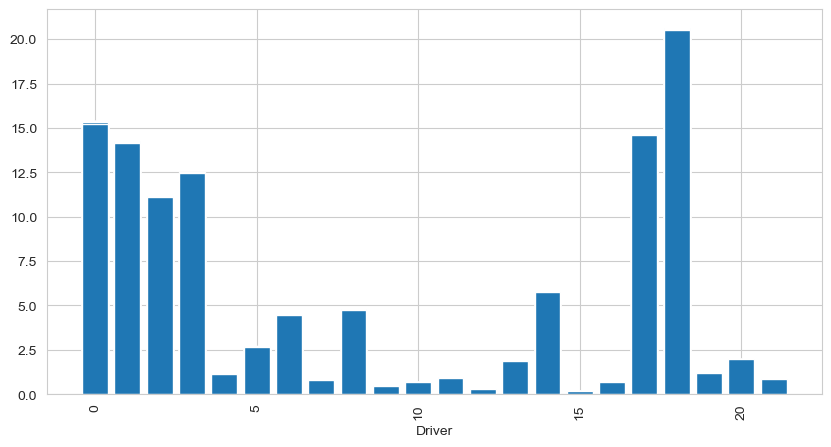

In [49]:
# Create a dictionary to map result with driver
data_dict = {}
data_dict['drivers_observed'] = list(drivers_observed)
data_dict['result_constraint'] = list(result_constraint)

dataset = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(10, 5))

#Ploting the data
plt.bar(data_dict['drivers_observed'] , data_dict['result_constraint'])

# ax.set_xticks(range(len(dataset)))
# ax.set_xticklabels(list(dataset['category']))
# ax.invert_yaxis()  # invert the y-axis
ax.set_xlabel('Driver')
# ax.set_ylabel('Talent')
plt.xticks(rotation=90)

plt.show()

Q. Is the hypothetical model where Charles Leclerc is a more talented driver than Max Verstappen still *possible*? Are posterior checks producing results in line with observations? Can you reject this model as an unlikely one?

<b>The hypothetical model where Charles Leclerc is a more talented driver than Max Verstappen is NOT PROBABLE. This is because the posterior checks producing results are in line with observations and hence we can not reject the model. 

# 10. Probability that Ferrari wins two consecutive races
Since we can produce simulated data that potentially covers all possible situations, it is straightforward now to extract conditional probabilities.

We need tons of data to cover edge cases, so let's produce *a million* simulated 2022 seasons.
```
pp_trace_f = pm.sample_ppc(trace, samples=1000000, model=...)
```

Then, compute the probability that Ferrari comes in 1/2 in any race in the 2022 season.

You should find it to be very small.

Indeed, Ferrari did not finish 1/2 in 2022.

But Mercedes and Red Bull [did](https://www.lightsoutblog.com/2022/11/16/the-last-1-2-finish-for-every-team-on-the-f1-grid/)!

This is another example of our universe producing stranger results than expected (and why we need the student-t distribution!)

In [50]:
pp_trace_f = pm.sample_posterior_predictive(trace, samples=1000000, model= F1_model)

In [52]:
#Create a list of positions where ferrari has played a race 
positions_ferrari = [x for x,y in enumerate(constructors_observed) if y == 0]
print(len(positions_ferrari))

35


In [59]:
#Calculating if ferrari came in the 1st and 2nd place


def ferrari_won_1_2(first,second):
    minimum_score=17
    return(first>minimum_score and second>minimum_score)

In [70]:
f_wins = 0
total_races = 0
for ind in range(len(pp_trace_f['points'])):
    for i in range(0,len(positions_ferrari)-1,2):
        total_races+=1
        if ferrari_won_1_2(pp_trace_f['points'][ind][positions_ferrari[i]],pp_trace_f['points'][ind][positions_ferrari[i+1]]):
            f_wins += 1 # Number of races ferrari came in 1st and 2nd position
print(f_wins)
print(total_races)
total_races += 1000000
# Adding 1000000 cause we have odd number of ferrari positions, we can conclude that there is one such race where
# only 1 ferrari participated 

1026938
17000000


In [74]:
# Now we have favourable outcomes of ferrari standing on 1st or 2nd position along with the total sample space, 
# We can calculatethe probability of ferrari coming 1st or 2nd in all the predictive sample values by using 
#p = (# of favourable outcomes)/(Total # of outcomes) 
p = (f_wins/total_races)
print("Probability of ferrari coming 1st and 2nd in a race is :" + str(p))

Probability of ferrari coming 1st and 2nd in a race is :0.05705211111111111
